###### Neccessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random
import math
import re
from IPython.display import clear_output
%matplotlib inline

###### Loading Dataset

In [126]:
tweets_df = pd.read_csv('Tweets.csv')
tweets_df = tweets_df.rename(columns={"airline_sentiment": "label"})

###### Analysing Dataset

In [127]:
tweets_df.head()

,label,text
0,neutral,@USAirways Is there a phone line to call into ...
1,positive,@united Bag was finally delivered and intact. ...
2,positive,@usairways Thanks to Kevin and team at F38ish ...
3,negative,"@AmericanAir Yes, talked to them. FLL says is ..."
4,negative,@VirginAmerica and it's a really big bad thing...


In [128]:
tweets_df.shape

(14640, 2)

Classes

In [129]:
classes = sorted(tweets_df['label'].unique())
classes

['negative', 'neutral', 'positive']

Add Comment
Skewed Dataset

Text(0.5, 0, 'Labels')

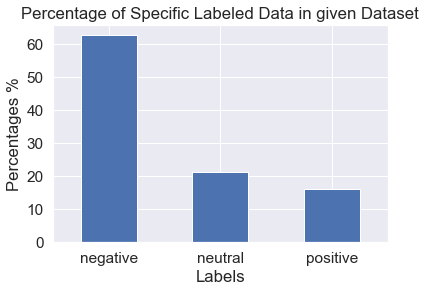

In [130]:
ax = (tweets_df['label'].value_counts(normalize=True)*100).plot(
        kind="bar", title='Percentage of Specific Labeled Data in given Dataset')
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('Percentages %')
ax.set_xlabel('Labels')

### Dataset Splitting (Stratified)

In [131]:
def split_dataset(df, classes, split=80, rand_factor=0):
    '''
        Performs stratified split
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
            
        classes: list
            List of unique classes of shape (k, ), where k is the number of classes
        
        split: int
            Spliting point
            
        rand_factor = int
            Number of times dataset should be randomized
        
        Returns
        --------
        train_df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
            
        test_df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
        '''
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    
    label_count = df['label'].value_counts()
    for i, c in enumerate(classes):
        temp_df = df[df['label'] == i].reset_index(drop=True)
        split_index = int(label_count[i] * (split/100))
        train_df = pd.concat([temp_df[:split_index], train_df], ignore_index=True)
        test_df = pd.concat([temp_df[split_index:], test_df], ignore_index=True)
        
    if rand_factor:
        for _ in range(rand_factor):
            train_df = train_df.sample(frac=1).reset_index(drop=True)
            test_df = test_df.sample(frac=1).reset_index(drop=True)
    
    return train_df, test_df

### Dataset Preprocessing

* Label Encoding

In [132]:
def LabelEncoder(df):
    '''
        Encodes Labels
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
        '''
    df['label'] = df['label'].astype('category')
    df['encoded_labels'] = df['label'].cat.codes

In [133]:
# Encoding Labels
LabelEncoder(tweets_df)
tweets_df = tweets_df.drop(columns=["label"])
tweets_df = tweets_df.rename(columns={"encoded_labels": "label"})
tweets_df.head()

,text,label
0,@USAirways Is there a phone line to call into ...,1
1,@united Bag was finally delivered and intact. ...,2
2,@usairways Thanks to Kevin and team at F38ish ...,2
3,"@AmericanAir Yes, talked to them. FLL says is ...",0
4,@VirginAmerica and it's a really big bad thing...,0


* Bag of Words (BOW)

In [134]:
def clean_text(text, stopwords=None):
    '''
        Cleans Text
        
        Arguments
        ---------
        text : str            
            
        stopwords: list
            Array of shape (x, ), where x is the number of stopwords 
        
        Returns
        --------
        cleaned_text: str
            Cleaned text
        '''
    cleaned_text = ""

    cleaned_text = re.sub("[^\w]", " ", text) # Removing punctautions
    cleaned_text = cleaned_text.lower() # Converting to lower case
    # Removing Stopwords
    if stopwords:
        cleaned_text = cleaned_text.split()
        cleaned_text = [x for x in cleaned_text if x not in stopwords]
        cleaned_text = " ".join(cleaned_text)
        
    return cleaned_text

def get_stopwords_and_vocab(texts, thresh=2):
    '''
        Extracts stopwords and vobcabulary from texts on the basis of a threshold
        
        Arguments
        ---------
        texts : list
            Array of shape (m, ), where m is number examples
            
        thresh: int
            Default value is 2
        
        Returns
        --------
        stop_words : list
            Array of shape (x, ), where x is the number of stop words
            
        vocab : list
            Array of shape (n, ), where n is the number of features
        '''
    stop_words, vocab = list(), list()
    
    # Stopwords from the texts
    # Creating Dictionary
    w_dict = dict()
    for text in texts:
        cleaned_text = clean_text(text).split()
        for word in cleaned_text:
            if word in w_dict:
                w_dict[word] += 1
            else:
                w_dict[word] = 1
    # Extracting Stopwords
    for word, count in w_dict.items():
        if count < thresh:
            stop_words.append(word)
        else:
            vocab.append(word)
    # Sorting
    stop_words, vocab = sorted(stop_words), sorted(vocab)
    
    return stop_words, vocab
    
def tokenize(text):
    '''
        Tokenizes sentence to words
        
        Arguments
        ---------
        text : str
        
        Returns
        --------
        tokenized_text: list
            Array of shape (n, ), where n is the number of words in text
        '''
    tokenized_text = None
    tokenized_text = text.split()
    return tokenized_text

def BOW(texts, vocab, stop_words):
    '''
        Make Bag Of Words Features of Texts
        
        Arguments
        ---------
        texts : list
            Array of shape (m, ), where m is number examples
            
        vocab : list
            Array of shape (n, ), where n is the number of features
        
        stop_words : list
            Array of shape (x, ), where x is the number of stop words
        
        Returns
        --------
        feature_vectors : numpy array
            Array of shape (m, n), where m is the number of examples and n is the number of features
        '''
    feature_vectors = list()
    
    # Initial Requirements
    for index, text in enumerate(texts):
        clear_output(wait=True)

        temp = np.zeros(len(vocab))
        cleaned_text = tokenize(clean_text(text, stopwords=stop_words))
        for i, word in enumerate(vocab):
            if word in cleaned_text:
                temp[i] += 1
        feature_vectors.append(temp)

        print("Building Feature Vectors Current Progress =", np.round((index+1)/len(texts) *100, 2), "%")
    print("Completed!!!")
    feature_vectors = np.array(feature_vectors)
    return feature_vectors

In [135]:
# Extracting Stopwords and Vocabulary
file = open("stopwords.txt", "r")
stop_words, vocab = get_stopwords_and_vocab(tweets_df['text'])
stop_words += file.read().split()
stop_words = sorted(stop_words)
file.close()

* Splitting

In [136]:
# Train-Test Split
full_train_df, test_df = split_dataset(tweets_df, classes, rand_factor=3)

In [137]:
# Train-Validation Split
train_df, val_df = split_dataset(full_train_df, classes, rand_factor=3)

* Extracting Features

In [138]:
def df_to_data(df, vocab, stopwords):
    '''
        Converts Dataframe to Numpy Array with combining labels and BOW features
        
        Arguments
        ---------
        texts : list
            Array of shape (m, ), where m is number examples
            
        vocab : list
            Array of shape (n, ), where n is the number of features
        
        stop_words : list
            Array of shape (x, ), where x is the number of stop words
        
        Returns
        --------
        data : numpy array
            Array of shape (m, n+1), where m is the number of examples and n is the number of features
        '''
    data = None
    data = BOW(df['text'], vocab, stopwords)
    data = np.insert(data, len(data[0]), df['label'], axis=1)
    return data

In [139]:
full_train_data = df_to_data(full_train_df, vocab, stop_words)

Building Feature Vectors Current Progress = 100.0 %
Completed!!!


In [140]:
test_data = df_to_data(test_df, vocab, stop_words)

Building Feature Vectors Current Progress = 100.0 %
Completed!!!


In [141]:
train_data = df_to_data(train_df, vocab, stop_words)

Building Feature Vectors Current Progress = 100.0 %
Completed!!!


In [142]:
val_data = df_to_data(val_df, vocab, stop_words)

Building Feature Vectors Current Progress = 100.0 %
Completed!!!


### Multiclass Logistic Regressor Class

In [145]:
class MULLR:
    '''
    A multiclass logistic regressor that trains its weights on given training data and then
    tests itself on testing data and shows result in the form of confusion matrix for all classes.
    '''
    def __init__(self, classes=None, alpha=0.5, num_epoch=100, conv_thresh=0.001, batch_size=32):
        '''
        Initializes all atributes to default values
        '''
        self.classes = classes
        self.batch_size = batch_size
        self.weights = None
        self.biases = None
        self.alpha = alpha
        self.num_epoch = num_epoch
        self.conv_thresh = conv_thresh
        self.error = 0.0
        
    def initialize(self, data):
        '''
        Initializes weights and biases.
        
        Arguments
        ---------
        data : numpy array
            Array of shape (m, n+1), where m is the number of examples and n is the number of features
        '''
        self.weights = np.zeros((len(self.classes), len(data[0])-1))
        self.biases = np.zeros(3)
    
    def softmax(self, x, y):
        '''
        Calculates softmax.
        
        Arguments
        ---------
        x : numpy array
            Feature vector of shape (n, ), where n is the number of features
            
        y : int
            Label
        
        Returns
        --------
        softmax : float
            The value after applying softmax.
        '''
        softmax = None
        z = np.array([(np.dot(np.transpose(self.weights[k]), x)+self.biases[k]) for k in range(len(self.classes))])
        z = self.scale(z)
        exp_y = np.exp(z[y])
        exp_all = np.sum(np.exp(z))
        softmax = exp_y / exp_all
        return softmax
    
    def predict_prob(self, x):
        '''
        Calculates probabilty of all labels using softmax
        
        Arguments
        ---------
        x : Numpy array
            Numpy array of shape (n, ), where n is number of features.
        
        Returns
        --------
        h_x : numpy array
            Array of shape (k, ), where k is the number of classes            
        '''
        h_x = None
        h_x = np.array([self.softmax(x, k) for k in range(len(self.classes))])
        return h_x
    
    def compute_cross_entropy_loss(self, X, Y):
        '''
        Calculates cross entropy loss over one example
        
        Arguments
        ---------
        X : Numpy array
            Numpy array of shape (x, ), where x is number of features.

        Y : int
            The label of example instance
        
        Returns
        --------
        ce_loss : float
            The value between 0 to nan(if prediction is 0).
        '''
        ce_loss = 0.0
        ce_loss = np.log(self.softmax(X, Y))
        return ce_loss
    
    def mini_batch(self, data, num_feature, start, end):
        '''
        Randomly selects given number of features from the data
        
        Arguments
        ---------
        data : numpy array
            Array of shape (m, n+1), where m is the number of examples and n is the number of features
           
        num_feature: int
            Number of features
        Returns
        --------
        X: Numpy array
            Array of shape (k, n), where k is the number of classes and n is the number of features
        '''
        X = [list() for _ in range(len(self.classes))]  
        mini_batch = data[start:end]
        # Separating data of all classes from mini_batch
        X_temp, Y_temp = mini_batch[:, 0:num_feature], mini_batch[:, num_feature].astype('int')
        for i in range(len(mini_batch)):
            X[Y_temp[i]].append(X_temp[i])
        X = np.array(X)
        return X
    
    def scale(self, X):
        '''
        Scales input to numbers of smaller range to avoid blowing up of softmax
        
        Arguments
        ---------
        X : numpy array
            Array of shape (k), where k is the number of classes
        Returns
        --------
        scaled : numpy array
            Array of shape (k), where k is the number of classes
        '''
        scaled = None
        scaled = X - np.max(X)
        return scaled
    
    def gradient_descent(self, data):
        '''
        Minimizes loss and updates the `self.weights` using Mini-Batch Gradient Descent
        
        Arguments
        ---------
        data : numpy array
            Array of shape (m, n+1), where m is the number of examples and n is the number of features   
        '''
        m = len(data) # number of training examples
        n = data[0].size - 1 # number of features
        Xd , Yd = data[:, 0:n], data[:, n].astype('int')
        old_cost = np.inf
        converged = False
        cost = np.NINF
        for i in range(self.num_epoch):
            clear_output(wait=True)
            start = 0
            end = self.batch_size
            completed = False
            while True:
                if completed:
                    break
                elif (start + self.batch_size) >= m:
                    start = end
                    end = m
                    completed = True                    
                X = self.mini_batch(data, n, start, end)
                start += self.batch_size
                end += self.batch_size
                # Computing Deltas
                for k in range(len(self.classes)):
                    m_k = len(X[k]) # Number of data points of k class in batch
                    if m_k:
                        pred_probs = np.array([(-1)*(1 - self.softmax(X[k][i], k)) for i in range(m_k)]) # 1 x m_k
                        # Updating Biases
                        b_delta = ((self.alpha*np.sum(pred_probs)) / m_k)
                        self.biases[k] -= b_delta
                        # Updating Weights
                        X_k = np.array(X[k]) # m_k x n
                        w_delta = ((self.alpha*(np.dot(pred_probs, X_k))) / m_k)
                        self.weights[k] -= w_delta

            # Adding the cost for current iteration
            cost = (-1/m)*np.sum(np.array([self.compute_cross_entropy_loss(Xd[i], Yd[i]) for i in range(m)]))
            print("Training Current Progress =", np.round((i+1)/self.num_epoch *100, 2), "% ---- Cost:", cost)

            # If the difference of two successive costs is less than the given threshold the model has converged
            if np.abs(old_cost-cost) < self.conv_thresh:
                print("Model Converged")
                converged = True
                break
            old_cost = cost
        print("Completed!!!")
        
        # Cost of model
        self.error_rate = cost
        if not converged:
            print("Model Didnot Converge")
    
    def train_model(self, data):
        '''
        Learns `self.weights` for the given data
        
        Arguments
        ---------
        data : numpy array
            Array of shape (m, n+1), where m is the number of examples and n is the number of features  
        '''
        self.initialize(data)
        self.gradient_descent(data)

    def prediction(self, x):
        '''
        Calculates predicted label

        Arguments
        ---------
        x : numpy array
            Array of shape (n, ), where n is the number of features

        Returns
        --------
        y_cap : int
            The encoded label according to the threshold.
        '''
        y_cap = ""
        pred_prob = self.predict_prob(x)
        y_cap = np.argmax(pred_prob)
        return y_cap
    
    def get_tp(self, cm, y):
        '''
        Calculates True Positives of given class w.r.t. other classes
        
        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
        
        y: int
            Label of given classe
        
        Returns
        --------
        tp: int
            True Positives
        '''
        tp = 0
        tp = cm[y][y]
        return tp
    
    def get_tn(self, cm, y):
        '''
        Calculates True Negatives of given class w.r.t. other classes
        
        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
        
        y: int
            Label of given classe
        
        Returns
        --------
        tn: int
            True Negatives
        '''
        tn = 0
        for i in range(len(cm)):
            if i != y:
                for j in range(len(cm)):
                    if j != y:
                        fp += cm[i][j]
        return tn                
    
    def get_fp(self, cm, y):
        '''
        Calculates False Positives of given class w.r.t. other classes
        
        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
        
        y: int
            Label of given classe
        
        Returns
        --------
        fp: int
            False Positives
        '''
        fp = 0
        for j in range(len(cm)):
            if j != y:
                fp += cm[y][j]
        return fp
    
    def get_fn(self, cm, y):
        '''
        Calculates False Negatives of given class w.r.t. other classes
        
        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
        
        y: int
            Label of given classe
        
        Returns
        --------
        fn: int
            False Negatives
        '''
        fn = 0
        for i in range(len(cm)):
            if i != y:
                fn += cm[i][y]
        return fn
    
    def precision(self, cm):
        '''
        Calculates Macro Precision
        
        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
        
        Returns
        --------
        precision: float
            Macro Precision
        '''
        precision = 0
        for i in range(len(cm)):
            temp = (self.get_tp(cm, i) + self.get_fp(cm, i))
            if temp:
                precision += (self.get_tp(cm, i) / temp)
        precision /= len(cm)
        return precision
    
    def recall(self, cm):
        '''
        Calculates Macro Recall
        
        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
        
        Returns
        --------
        recall: float
            Macro Recall
        '''
        recall = 0
        for i in range(len(cm)):
            temp = (self.get_tp(cm, i) + self.get_fn(cm, i))
            if temp:
                recall += (self.get_tp(cm, i) / temp)
        recall /= len(cm)
        return recall
    
    def test_model(self, data):
        '''
          Tests model based on learned weights and creates confusion matrix.
          
          Arguments
          ---------
          data : numpy array
            Array of shape (m, n+1), where m is the number of examples and n is the number of features
        '''
        print("Testing and Building Confusion Matrix .....")
        m = len(data)
        n = data[0].size-1
        X , Y = data[:, 0:n], data[:, n].astype('int')
        
        cm = np.zeros((len(self.classes), len(self.classes)))
        
        for i in range(m):
            y_cap = self.prediction(X[i])
            cm[y_cap][Y[i]] += 1

        self.evaluation_matrix(cm)

        # Calculating Accuracy, Precision, Recall and F1 Score
        accuracy = np.sum(np.array([self.get_tp(cm, i) for i in range(len(cm))])) / np.sum(cm)
        precision = self.precision(cm)
        recall = self.recall(cm)
        f1_score = ((2*recall*precision) / (recall + precision))
        print("\n\nAccuracy = %.3f" % (accuracy))
        print("Precision = %.3f" % (precision))
        print("Recall = %.3f" % (recall))
        print("F1 Score = %.3f" % (f1_score)) 
        
    def evaluation_matrix(self, cm):
        '''
            Plots confusion matrix.
            
            Arguments
            ---------
            cm: numpy array
                Array of shape (k, k), where k is the number of classes
        '''
        df_cm = pd.DataFrame(cm, index = [i for i in self.classes],
                  columns = [i for i in self.classes])
        sn.set(font_scale=1.4)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="BuPu")
        plt.show()

###### Training For Train Set

In [146]:
A = MULLR(classes=classes, alpha=0.05, num_epoch=200, conv_thresh=0.0001, batch_size=32)
A.train_model(train_data)

Training Current Progress = 91.0 % ---- Cost: 0.5895152097905868
Model Converged
Completed!!!


###### Testing on Train Set

Testing and Building Confusion Matrix .....


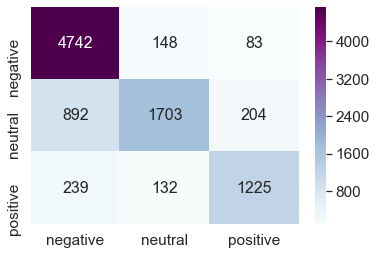



Accuracy = 0.819
Precision = 0.777
Recall = 0.825
F1 Score = 0.800


In [147]:
A.test_model(train_data)

###### Testing on Validation Set (For Training Parameters)

Testing and Building Confusion Matrix .....


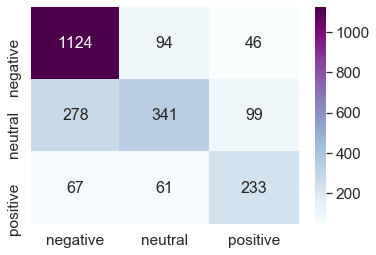



Accuracy = 0.725
Precision = 0.670
Recall = 0.690
F1 Score = 0.680


In [148]:
A.test_model(val_data)

#### Training after tunning parameters

In [149]:
A.train_model(full_train_data)

Training Current Progress = 43.0 % ---- Cost: 0.6463640837067026
Model Converged
Completed!!!


Testing and Building Confusion Matrix .....


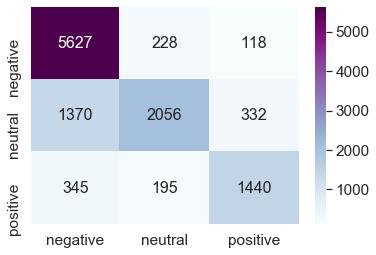



Accuracy = 0.779
Precision = 0.739
Recall = 0.786
F1 Score = 0.762


In [150]:
A.test_model(full_train_data)

### Evaluation Report

Testing and Building Confusion Matrix .....


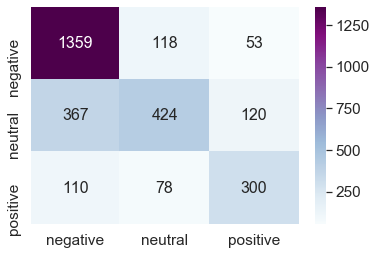



Accuracy = 0.711
Precision = 0.656
Recall = 0.686
F1 Score = 0.671


In [151]:
A.test_model(test_data)

* **Accuracy = 0.711**
* **Precision = 0.656**
* **Recall = 0.686**
* **F1 Score = 0.671**
* Here I have presented **Macro Scores** because dataset is more skewed towards negative class (that's shown in bar graph under Analysing Dataset Section). I have tunned the parameters of my model on the basis of validation set scores. After all tunning, trained it also on validation set and tested on new test data set.
* I have also evaluted training data set, by testing my model on it, to avoid over-fitting.